# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

This time, only using month and county as fixed effects and nothing else. 

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [3]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

# Read in data

In [4]:
# read in our modeling data
df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

# read in cornelia's healthcare data
df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]

# Data clean

Clean med data

In [5]:
# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + df2['patzip_year_month'].to_list() + df3['patzip_year_month'].to_list()
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')

df_med.head(3)

,patzip_year_month,hematopoietic_cancers,number_of_visits_hem_cancers,pediatric_vasculitis,number_of_visits_vasc,type_1_diabetes,number_of_visits_diab
0,92119-2011-9,1.0,17.0,NaN,NaN,NaN,NaN
1,91384-2016-12,1.0,18.0,NaN,NaN,NaN,NaN
2,92129-2016-1,NaN,NaN,NaN,NaN,1.0,17.0


Join med data

In [6]:
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 'pediatric_vasculitis', 
  'number_of_visits_vasc', 'type_1_diabetes', 'number_of_visits_diab']
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

print(df.shape[0])

311163


Var transformations

In [7]:
# Create response variables, which is visits / population
df['y_hematopoietic'] = df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = df['number_of_visits_diab'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

Define all variables we'll be using

In [8]:
# exclude baseline var
x_months = [i for i in df.columns if (re.search('month_', i) and i not in 'month_01')]
x_county = [i for i in df.columns if (re.search('school_county_v2_', i)) and i not in 'school_county_v2_los_angeles']
x_fixed_effects = x_months + x_county

other_vars_to_keep = ['month_01', 'school_county_v2_los_angeles']
instrument = ['avg_wind_alignment_cosine']
y_pm25_log = ['pm25_log']
y_pm25 = ['pm25']
y_med = ['y_hematopoietic', 'y_vasculitis', 'y_diabetes']

all_vars_to_keep = list(set(x_fixed_effects + other_vars_to_keep + instrument + y_pm25_log + y_pm25 + y_med))

Select only necessary columns, and remove all NA values

In [9]:
# get complete data
print(f'num rows to start: {df.shape[0]}')

df_modeling = df[all_vars_to_keep]

for var in df_modeling.columns:
  df_modeling = df_modeling[~df_modeling[var].isna()]

print(f'num rows after filtering: {df_modeling.shape[0]}')

num rows to start: 311163
num rows after filtering: 311163


# Create interaction effect vars

In [10]:
counter = 0 
for m in [i for i in df_modeling.columns if re.search('month_', i)]:
  for c in [i for i in df_modeling.columns if re.search('school_county_v2_', i)]:
    counter += 1

counter

696

In [13]:
interaction_cols = []
interaction_col_names = []
baseline_interaction = 'month_01_school_county_v2_los_angeles'
for m in [i for i in df_modeling.columns if re.search('month_', i)]:
  for c in [i for i in df_modeling.columns if re.search('school_county_v2_', i)]:
    new_var = m + '_' + c
    if new_var != baseline_interaction:
      interaction_col_names.append(new_var)
      res = pd.DataFrame({new_var: df_modeling[m] * df_modeling[c]})
      interaction_cols.append(res)

df_modeling = pd.concat([df_modeling]+interaction_cols, axis=1)
print(df_modeling.shape)

(311163, 771)

In [14]:
# update fixed effects
x_fixed_effects += interaction_col_names

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

RMSE: 4.595582098528796
                            OLS Regression Results                            
Dep. Variable:                   pm25   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     310.4
Date:                Tue, 18 Oct 2022   Prob (F-statistic):               0.00
Time:                        08:47:39   Log-Likelihood:            -9.1607e+05
No. Observations:              311163   AIC:                         1.834e+06
Df Residuals:                  310466   BIC:                         1.841e+06
Df Model:                         696                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

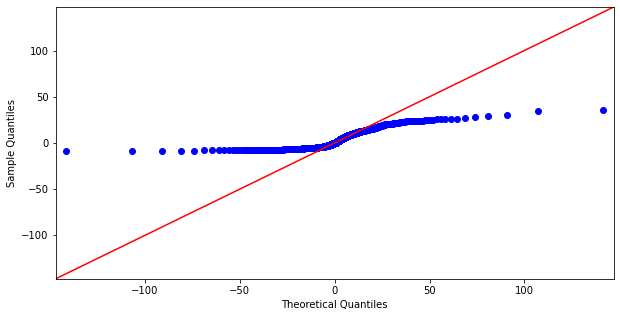

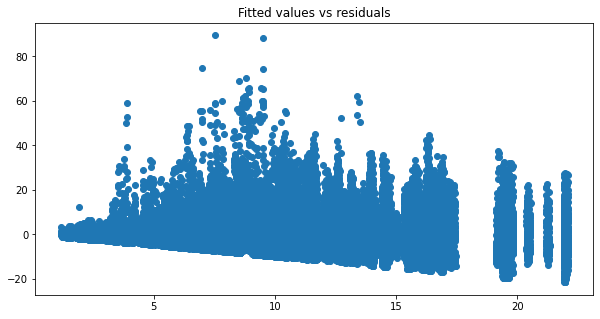

In [16]:
#X = sm.add_constant(df_modeling[x_fixed_effects + instrument])
X = sm.add_constant(df_modeling[instrument + x_fixed_effects])
y = df_modeling['pm25']
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df_modeling['yhat_pm25'] = fit1.fittedvalues.values

# resid
resids = fit1.resid
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

#p-values
#fit1.pvalues

# rmse
rmse = np.mean(np.array(df_modeling['yhat_pm25'] - df_modeling['pm25']) ** 2) ** .5
print(f'RMSE: {rmse}')

# model summary
print(fit1.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted['fitted'], resids_and_fitted['resids'])
plt.title('Fitted values vs residuals')
plt.show()

<AxesSubplot:>

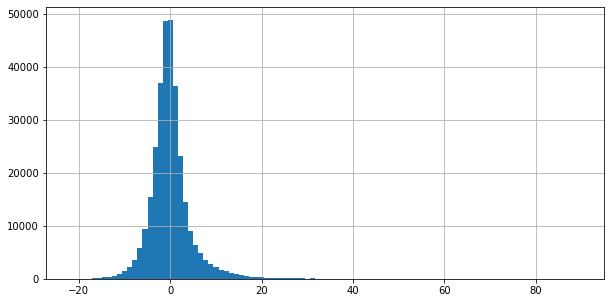

In [17]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

# Second Stage Regression

- Stage 1 of the least squares regression: $\hat{x} = z \delta$.
  - $\hat{x}$ = Predicted pm2.5 amounts ($\hat{pm2.5}$). We'll use this predicted var to predict our final Y, health outcomes. 
  - $z$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 
  
- Stage 2 of the equation: $\hat{y} = \hat{x} \beta$
  - $\hat{y}$ = predicted medical outcome
  - $\hat{x}$ = predicted pm2.5 amt from the first stage. But we also should include the other exogenous vars. 

p-value: 0.9797321491742366
                            OLS Regression Results                            
Dep. Variable:        y_hematopoietic   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.109
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           4.63e-57
Time:                        08:54:43   Log-Likelihood:             1.4624e+06
No. Observations:              311163   AIC:                        -2.923e+06
Df Residuals:                  310466   BIC:                        -2.916e+06
Df Model:                         696                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

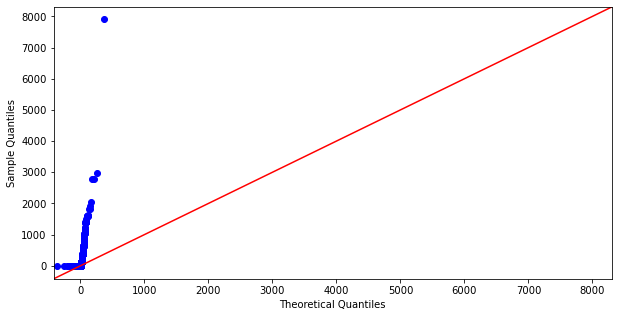

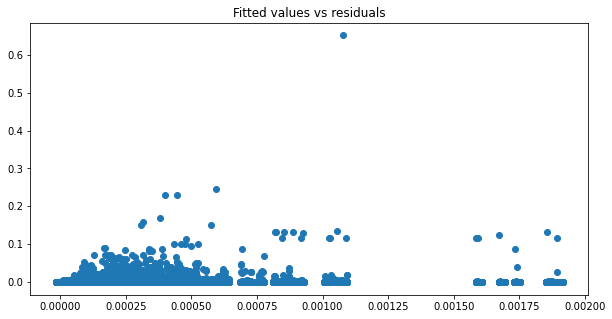

In [18]:
X = sm.add_constant(df_modeling[['yhat_pm25'] + x_fixed_effects])
y = df_modeling['y_hematopoietic']
fit2_hema = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_hema.resid
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

# p-value
# print(f'p-value: {fit2_hema.pvalues.to_frame().iloc[-1][0]}')

print(fit2_hema.summary())

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_hema['fitted'], resids_and_fitted_hema['resids'])
plt.title('Fitted values vs residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:           y_vasculitis   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.333
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.24e-75
Time:                        09:01:52   Log-Likelihood:             1.5944e+06
No. Observations:              311163   AIC:                        -3.187e+06
Df Residuals:                  310466   BIC:                        -3.180e+06
Df Model:                         696                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

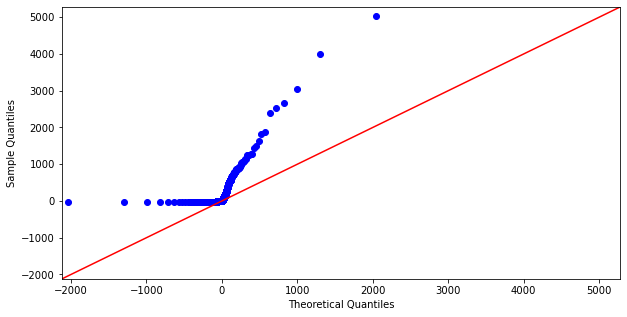

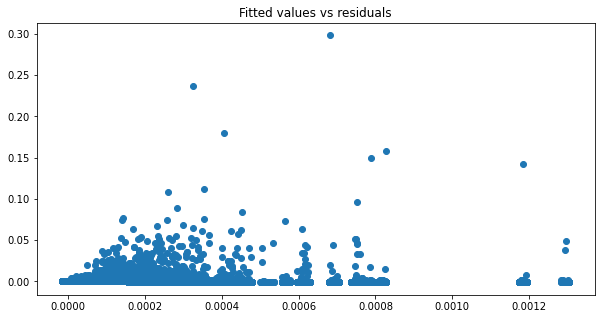

In [19]:
X = sm.add_constant(df_modeling[['yhat_pm25'] + x_fixed_effects])
y = df_modeling['y_vasculitis']
fit2_vasc = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values
# resid
resids = fit2_vasc.resid
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print(fit2_vasc.summary())

# p-value
# print(f'p-value: {fit2_vasc.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(resids, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_vasc['fitted'], resids_and_fitted_vasc['resids'])
plt.title('Fitted values vs residuals')
plt.show()

                            OLS Regression Results                            
Dep. Variable:             y_diabetes   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.018
Date:                Tue, 18 Oct 2022   Prob (F-statistic):              0.361
Time:                        09:08:39   Log-Likelihood:             1.1559e+06
No. Observations:              311163   AIC:                        -2.310e+06
Df Residuals:                  310466   BIC:                        -2.303e+06
Df Model:                         696                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

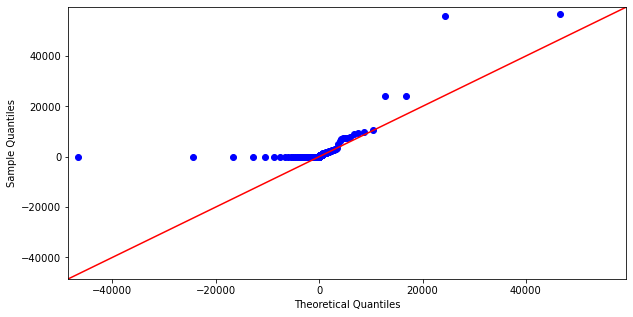

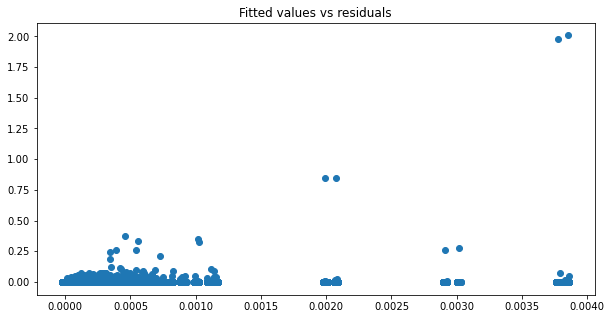

In [20]:
X = sm.add_constant(df_modeling[['yhat_pm25'] + x_fixed_effects])
y = df_modeling['y_diabetes']
fit2_diab = sm.OLS(y, X).fit()

# add fitted y value to our dataset
#df_modeling['yhat_pm25'] = fit2.fittedvalues.values 

resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print(fit2_diab.summary())

# p-value
# print(f'p-value: {fit2_diab.pvalues.to_frame().iloc[-1][0]}')

# qqplot
import scipy.stats as stats
plt.rcParams["figure.figsize"] = (10,5)
fig = sm.qqplot(fit2_diab.resid, stats.t, fit=True, line="45")
plt.show()

# resid vs fitted
plt.scatter(resids_and_fitted_diab['fitted'], resids_and_fitted_diab['resids'])
plt.title('Fitted values vs residuals')
plt.show()

# Results Summary

In [49]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

In [50]:
get_ols_res(fit2_diab)

,variable,coef,p_value,95_ci_lower,95_ci_upper
0,const,0.003066,0.346549,-3.318071e-03,9.450236e-03
1,yhat_pm25,-0.000189,0.350429,-5.845106e-04,2.072867e-04
2,month_02,-328536.790814,0.997016,-1.724982e+08,1.718411e+08
3,month_03,-328663.467385,0.997016,-1.725647e+08,1.719074e+08
4,month_04,-328475.406074,0.997016,-1.724660e+08,1.718090e+08
...,...,...,...,...,...
760,month_03_school_county_v2_tulare,50951.235558,0.997016,-2.665004e+07,2.675194e+07
761,month_03_school_county_v2_yolo,50398.273623,0.997016,-2.636081e+07,2.646161e+07
762,month_03_school_county_v2_butte,44756.112418,0.997016,-2.340968e+07,2.349919e+07
763,month_03_school_county_v2_mono,50729.029606,0.997016,-2.653381e+07,2.663527e+07


# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


              wind_bearing   hema_resids   vasc_resids   diab_resids
wind_bearing  1.000000e+00  2.834579e-07 -2.944685e-08 -1.262324e-07
hema_resids   2.834579e-07  1.000000e+00  2.201997e-02  1.449595e-03
vasc_resids  -2.944685e-08  2.201997e-02  1.000000e+00  1.400869e-03
diab_resids  -1.262324e-07  1.449595e-03  1.400869e-03  1.000000e+00


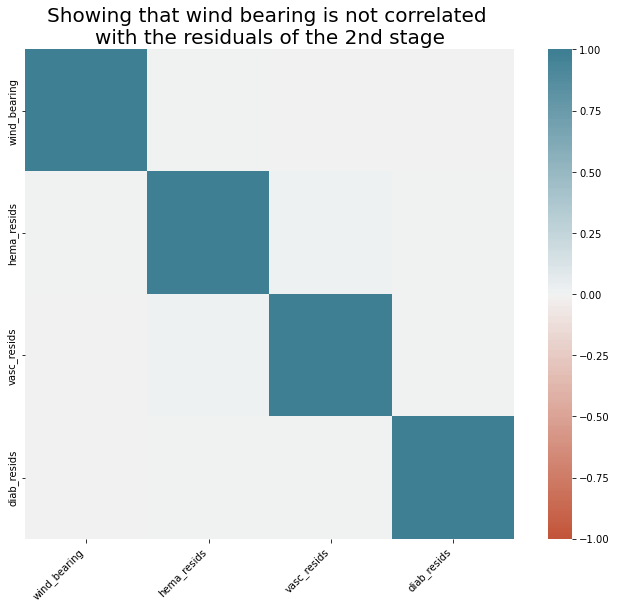

In [21]:
df_corr = pd.DataFrame({
  'wind_bearing': df_modeling['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)